# Valence class classification

In [ ]:
#!pip install AutoViz
#!pip install xlrd
!pip install imbalanced-learn

In [102]:
# Loading all the modules that I will use in this notebook
from itertools import product


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from autoviz.AutoViz_Class import AutoViz_Class

import imblearn
from sklearn.preprocessing import StandardScaler,MinMaxScaler, LabelEncoder

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import cudf, cuml
from xgboost import XGBRegressor
from cuml.neighbors import KNeighborsRegressor as knnCMR
from cuml.ensemble import RandomForestRegressor as rfCMR
from xgboost import XGBClassifier
from cuml.neighbors import KNeighborsClassifier as knnCMC
from cuml.ensemble import RandomForestClassifier as rfCMC

### 1. Load Data

In [103]:
# Loading the train, test and validation data(datasets) + looking the first 5 rows of the train dataset as confirmation that the data is loaded
train = pd.read_csv('../input/classification/classification/train/videos_emg_features_05_01_train.csv')
validation = pd.read_csv('../input/classification/classification/validation/videos_emg_features_05_01_validation.csv')
test = pd.read_csv('../input/classification/classification/test/videos_emg_features_05_01_test.csv')
train.head()

,Subject,0_iav,0_aac,0_ar1,0_ar2,0_ar3,0_ar4,0_cc1,0_cc2,0_cc3,...,6_mnp,6_ttp,6_vcf,6_psr,6_ohm,6_maxx,video,arousal,valence,class
0,Subject 26,0.000693,0.000002,-0.294017,0.193476,-0.557275,0.585870,0.294017,-0.221918,0.433606,...,2.467522e-15,6.193481e-13,175910.121778,175910.121778,1.136194,3.597469e-07,GroupA\01,4.0,5.0,neutral
1,Subject 26,0.000678,0.000001,-0.226482,0.115931,-0.460327,0.567215,0.226482,-0.129059,0.400917,...,2.244050e-15,5.632566e-13,178406.356796,178406.356796,1.132120,3.404466e-07,GroupA\01,4.0,5.0,neutral
2,Subject 26,0.000646,0.000001,-0.211141,0.078928,-0.399045,0.543397,0.211141,-0.087260,0.364224,...,2.276071e-15,5.712938e-13,195627.240519,195627.240519,1.143079,3.235088e-07,GroupA\01,4.0,5.0,neutral
3,Subject 26,0.000645,0.000001,-0.194372,0.068487,-0.398650,0.522556,0.194372,-0.075143,0.368694,...,2.158618e-15,5.418131e-13,195613.944335,195613.944335,1.141087,3.025860e-07,GroupA\01,4.0,5.0,neutral
4,Subject 26,0.000667,0.000001,-0.202488,0.095966,-0.396178,0.539132,0.202488,-0.105682,0.354309,...,2.189921e-15,5.496702e-13,186209.998678,186209.998678,1.135205,2.963975e-07,GroupA\01,4.0,5.0,neutral


### 2. Basic Data Exploration

In [104]:
# Basic info about the size(rows+colums) of the dataset, the memory usage and the datatypes of the data in the train dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136900 entries, 0 to 136899
Columns: 243 entries, Subject to class
dtypes: float64(240), object(3)
memory usage: 253.8+ MB


In [105]:
# Basic info about the size(rows+colums) of the dataset, the memory usage and the datatypes of the data in the validation dataset
validation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34022 entries, 0 to 34021
Columns: 243 entries, Subject to class
dtypes: float64(240), object(3)
memory usage: 63.1+ MB


In [106]:
# Basic info about the size(rows+colums) of the dataset, the memory usage and the datatypes of the data in the test dataset
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30791 entries, 0 to 30790
Columns: 243 entries, Subject to class
dtypes: float64(240), object(3)
memory usage: 57.1+ MB


In [107]:
# The names of the columns(features) of the train dataset(basically they are same for the train, validation and test datasets)
print(train.columns.to_list())

['Subject', '0_iav', '0_aac', '0_ar1', '0_ar2', '0_ar3', '0_ar4', '0_cc1', '0_cc2', '0_cc3', '0_cc4', '0_dasdv', '0_kurt', '0_log', '0_mav1', '0_mav2', '0_mav', '0_mhw', '0_mtw', '0_rms', '0_skew', '0_ssi', '0_tm', '0_var', '0_v_order', '0_wl', '0_mnf', '0_mdf', '0_pkf', '0_mnp', '0_ttp', '0_vcf', '0_psr', '0_ohm', '0_maxx', '1_iav', '1_aac', '1_ar1', '1_ar2', '1_ar3', '1_ar4', '1_cc1', '1_cc2', '1_cc3', '1_cc4', '1_dasdv', '1_kurt', '1_log', '1_mav1', '1_mav2', '1_mav', '1_mhw', '1_mtw', '1_rms', '1_skew', '1_ssi', '1_tm', '1_var', '1_v_order', '1_wl', '1_mnf', '1_mdf', '1_pkf', '1_mnp', '1_ttp', '1_vcf', '1_psr', '1_ohm', '1_maxx', '2_iav', '2_aac', '2_ar1', '2_ar2', '2_ar3', '2_ar4', '2_cc1', '2_cc2', '2_cc3', '2_cc4', '2_dasdv', '2_kurt', '2_log', '2_mav1', '2_mav2', '2_mav', '2_mhw', '2_mtw', '2_rms', '2_skew', '2_ssi', '2_tm', '2_var', '2_v_order', '2_wl', '2_mnf', '2_mdf', '2_pkf', '2_mnp', '2_ttp', '2_vcf', '2_psr', '2_ohm', '2_maxx', '3_iav', '3_aac', '3_ar1', '3_ar2', '3_ar3'

In [108]:
# The datatypes of each feature
print(train.dtypes.to_list())

[dtype('O'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'

In [109]:
# All the features which datatype is object(string)
print(train.select_dtypes(include=['object']).columns.to_list())

['Subject', 'video', 'class']


In [110]:
# The shape of the train, validation, test datasets(number of rows + colums)
print(train.shape)
print(validation.shape)
print(test.shape)

(136900, 243)
(34022, 243)
(30791, 243)


In [111]:
# Some basic statistics about the train dataset(for every feature)
train.describe()

,0_iav,0_aac,0_ar1,0_ar2,0_ar3,0_ar4,0_cc1,0_cc2,0_cc3,0_cc4,...,6_mdf,6_pkf,6_mnp,6_ttp,6_vcf,6_psr,6_ohm,6_maxx,arousal,valence
count,136900.000000,1.369000e+05,136900.000000,136900.000000,136900.000000,136900.000000,136900.000000,136900.000000,136900.000000,136900.000000,...,136900.000000,136900.000000,1.369000e+05,1.369000e+05,136900.000000,136900.000000,136900.000000,1.369000e+05,136900.000000,136900.000000
mean,0.000962,2.011216e-06,-0.271099,0.044827,-0.468986,0.479032,0.271099,-0.052796,0.424350,-0.796404,...,797.182504,643.969365,8.603373e-15,2.159447e-12,226518.552672,226518.552672,1.124445,3.803549e-07,4.027392,4.858254
std,0.001095,2.205904e-06,0.055585,0.129302,0.162632,0.278002,0.055585,0.148736,0.090637,0.497404,...,167.655869,200.395509,6.309540e-14,1.583695e-11,73350.152853,73350.152853,0.021839,5.015984e-07,2.387450,2.051504
min,0.000079,5.298191e-22,-0.646185,-1.010335,-1.278402,-0.188837,-0.770062,-0.843842,-0.528635,-4.527535,...,30.720000,0.000000,4.815219e-47,1.208620e-44,10376.386606,10376.386606,1.000986,1.018363e-07,1.000000,1.000000
25%,0.000457,1.126037e-06,-0.306377,-0.046400,-0.548088,0.259662,0.238753,-0.136083,0.363811,-1.185796,...,665.600000,522.240000,5.877735e-16,1.475311e-13,160450.658424,160450.658424,1.109027,1.668098e-07,2.000000,3.000000
50%,0.000647,1.410171e-06,-0.273208,0.025893,-0.429214,0.482127,0.273208,-0.029235,0.426405,-0.750072,...,747.520000,604.160000,1.228682e-15,3.083992e-13,237748.170152,237748.170152,1.124208,2.363802e-07,4.000000,5.000000
75%,0.001081,2.093361e-06,-0.238753,0.118917,-0.360350,0.700024,0.306377,0.052279,0.487836,-0.401789,...,911.360000,706.560000,4.271765e-15,1.072213e-12,287975.965854,287975.965854,1.138832,4.407158e-07,6.000000,6.000000
max,0.034699,7.104418e-05,0.770062,0.748818,0.935470,1.840554,0.646185,0.694043,0.973251,0.359982,...,2549.760000,2560.000000,2.593379e-12,6.509381e-10,882278.729335,882278.729335,1.750818,1.194507e-05,9.000000,9.000000


In [112]:
# Looking if there are any NaN/Null values in the train dataset
train.isna().sum().sum()

0

In [113]:
# Looking if there are any NaN/Null values in the validation dataset
validation.isna().sum().sum()

0

In [114]:
# Looking if there are any NaN/Null values in the test dataset
test.isna().sum().sum()

0

### 3. EDA, Visualization

In [115]:
# Getting the unique values of the valence column from the train dataset
valences=train["valence"]
unique_valences, num_examples_per_valence = np.unique(valences, return_counts = True)
unique_valences

array([1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [116]:
# Getting the unique values of the class column from the train dataset
classes=train["class"]
unique_classes, num_examples_per_class = np.unique(classes, return_counts = True)
unique_classes

array(['negative', 'neutral', 'positive'], dtype=object)

In [117]:
# Calculating the percentages of how many entries are negative, neutral and positive(from the class)
negative_perc=num_examples_per_class[0]/(num_examples_per_class.sum())*100
positive_perc=num_examples_per_class[2]/(num_examples_per_class.sum())*100
neutral_perc=num_examples_per_class[1]/(num_examples_per_class.sum())*100
neutral_perc

53.21183345507669

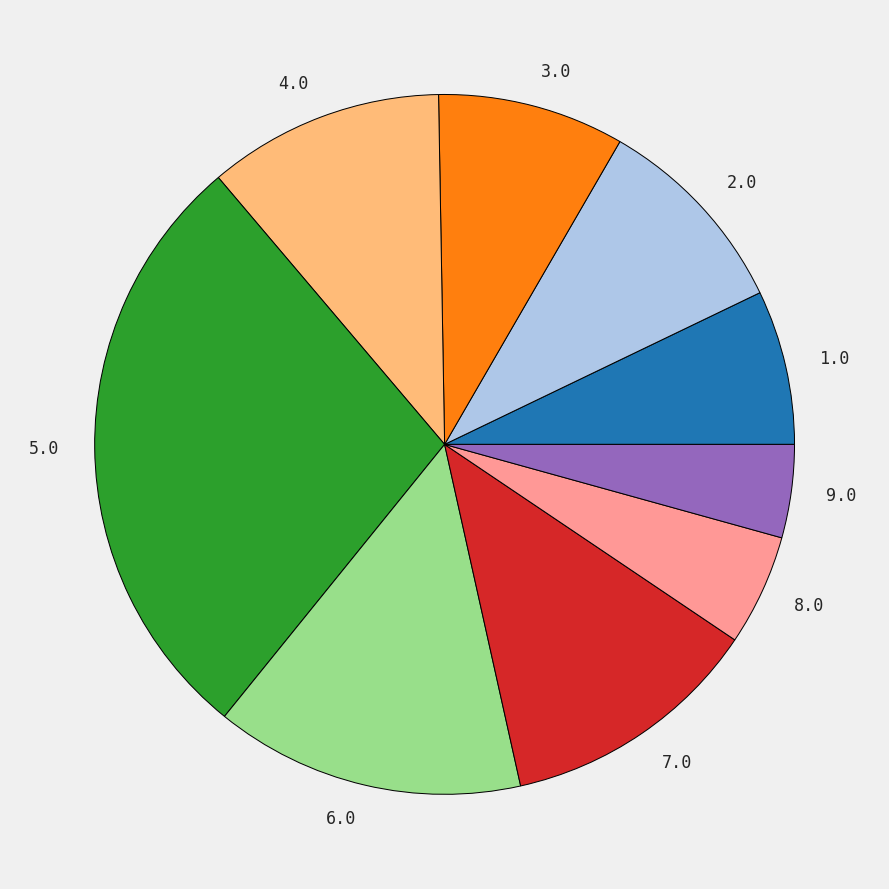

In [118]:
# Plotting the distribution of the valence per entries
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (15, 15))

# define the color palette which we will use
cmap = plt.get_cmap("tab20")
# sample as many colors from the palette as there are unique activites, so that each activity will be represented by a different color
sampled_colors = [cmap(i) for i in range (len(num_examples_per_valence))]

# use the pie chart function in the pyplot module to visualize the activity distributions
ax.pie(x = num_examples_per_valence, 
       colors = sampled_colors,
       labels = unique_valences, 
       wedgeprops= {'linewidth': 1, 
                    'edgecolor': 'black'}, 
       textprops = {'size': 'large', 
                    'family': "monospace",
                    'weight': 'medium'} 
);

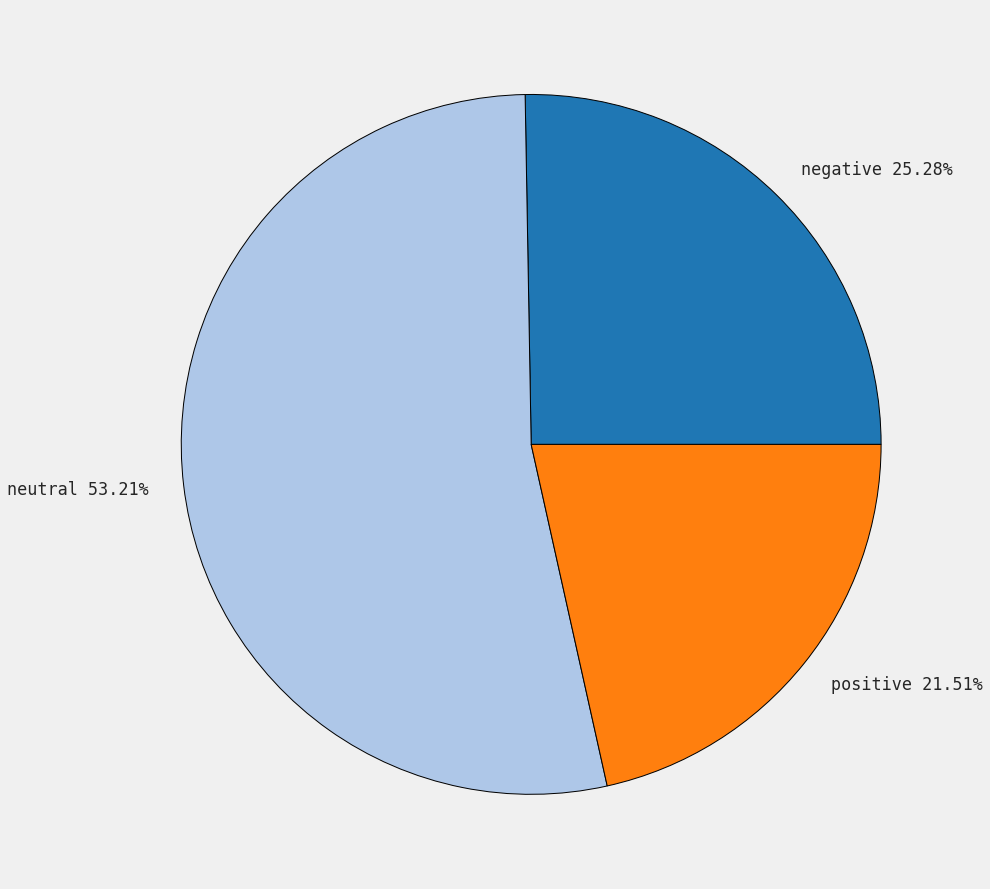

In [119]:
# Plotting the distribution of classes per entry
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (15, 15))
# define the color palette which we will use
cmap = plt.get_cmap("tab20")
neg= "{:.2f}".format(negative_perc)
neut= "{:.2f}".format(neutral_perc)
pos = "{:.2f}".format(positive_perc)
my_labels=['','','']
my_labels[0]=unique_classes[0]+" "+str(neg)+"%"
my_labels[1]=unique_classes[1]+" "+str(neut)+"%"
my_labels[2]=unique_classes[2]+" "+str(pos)+"%"
# sample as many colors from the palette as there are unique activites, so that each activity will be represented by a different color
sampled_colors = [cmap(i) for i in range (len(num_examples_per_class))]
ax.pie(x = num_examples_per_class, 
       colors = sampled_colors,
       labels = my_labels, 
       wedgeprops= {'linewidth': 1, 
                    'edgecolor': 'black'}, 
       textprops = {'size': 'large', 
                    'family': "monospace",
                    'weight': 'medium'} 
);

In [ ]:
# Auto visualization of all the features of the dataset
#AV = AutoViz_Class()
#viz = AV.AutoViz('../input/classification/classification/train/videos_emg_features_05_01_train.csv')

### 4. Data Preprocessing + Data Split

In [120]:
# From train dataset remove every second row with neutral class to basically undersample it
train_no_neutral = train[train["class"] != "neutral"]
train_neutral = train[train["class"] == "neutral"]
train_neutral = train_neutral.iloc[::2,:]
train = pd.concat([train_no_neutral, train_neutral])

In [121]:
# Getting the unique values of the class column from the train dataset
classes=train["class"]
unique_classes, num_examples_per_class = np.unique(classes, return_counts = True)
unique_classes

array(['negative', 'neutral', 'positive'], dtype=object)

In [122]:
# The neutral class in percentage
neutral_perc=num_examples_per_class[1]/(num_examples_per_class.sum())*100
neutral_perc

36.25108233725131

In [123]:
train.shape

(100477, 243)

In [124]:
# From the train dataset dropping all the columns(info) about the subject, video, arousal
train = train.drop(['Subject' ,'video', 'arousal'], axis = 1)
train.head()

,0_iav,0_aac,0_ar1,0_ar2,0_ar3,0_ar4,0_cc1,0_cc2,0_cc3,0_cc4,...,6_mdf,6_pkf,6_mnp,6_ttp,6_vcf,6_psr,6_ohm,6_maxx,valence,class
1425,0.000457,0.000001,-0.304558,0.033892,-0.436900,0.288169,0.304558,-0.039053,0.419838,-0.469645,...,696.32,614.40,9.611239e-16,2.412421e-13,257084.754572,257084.754572,1.155056,2.074795e-07,8.0,positive
1426,0.000445,0.000001,-0.282495,0.055604,-0.420825,0.315732,0.282495,-0.063458,0.394120,-0.502387,...,686.08,614.40,1.011924e-15,2.539930e-13,246597.071245,246597.071245,1.153380,2.246294e-07,8.0,positive
1427,0.000456,0.000001,-0.291795,0.102708,-0.417988,0.347847,0.291795,-0.117692,0.368794,-0.540273,...,706.56,460.80,9.747226e-16,2.446554e-13,257730.115240,257730.115240,1.154494,2.311558e-07,8.0,positive
1428,0.000456,0.000001,-0.285606,0.076205,-0.403359,0.349487,0.285606,-0.087088,0.368231,-0.542524,...,727.04,460.80,9.342239e-16,2.344902e-13,262742.028706,262742.028706,1.153435,2.230335e-07,8.0,positive
1429,0.000449,0.000001,-0.286187,0.083875,-0.415130,0.346961,0.286187,-0.095877,0.375329,-0.542297,...,778.24,532.48,8.411788e-16,2.111359e-13,278349.961286,278349.961286,1.152133,2.159123e-07,8.0,positive


In [125]:
# From the validation dataset dropping all the columns(info) about the subject, video, arousal
validation = validation.drop(['Subject' ,'video', 'arousal'], axis = 1)
validation.head()

,0_iav,0_aac,0_ar1,0_ar2,0_ar3,0_ar4,0_cc1,0_cc2,0_cc3,0_cc4,...,6_mdf,6_pkf,6_mnp,6_ttp,6_vcf,6_psr,6_ohm,6_maxx,valence,class
0,0.000441,0.000001,-0.334551,0.017524,-0.348620,0.210088,0.334551,-0.020455,0.341489,-0.317702,...,993.28,532.48,5.839758e-16,1.465779e-13,284079.951714,284079.951714,1.113174,1.632425e-07,8.0,positive
1,0.000470,0.000001,-0.345069,0.022060,-0.273772,0.259987,0.345069,-0.025867,0.266691,-0.363991,...,829.44,532.48,6.813120e-16,1.710093e-13,301391.185259,301391.185259,1.137440,1.735655e-07,8.0,positive
2,0.000466,0.000001,-0.358741,0.042098,-0.279966,0.276975,0.358741,-0.049649,0.266066,-0.387515,...,870.40,532.48,6.865532e-16,1.723249e-13,317636.011109,317636.011109,1.136466,1.828983e-07,8.0,positive
3,0.000442,0.000001,-0.267404,0.049737,-0.361819,0.248929,0.267404,-0.056387,0.341417,-0.376413,...,1003.52,542.72,6.021871e-16,1.511490e-13,318048.430724,318048.430724,1.122141,1.671134e-07,8.0,positive
4,0.000429,0.000001,-0.250008,0.032683,-0.337250,0.266309,0.250008,-0.036769,0.324850,-0.396075,...,1013.76,1280.00,6.032106e-16,1.514059e-13,300760.143538,300760.143538,1.116330,1.739748e-07,8.0,positive


In [126]:
# From the test dataset dropping all the columns(info) about the subject, video, arousal
test = test.drop(['Subject' ,'video', 'arousal'], axis = 1)
test.head()

,0_iav,0_aac,0_ar1,0_ar2,0_ar3,0_ar4,0_cc1,0_cc2,0_cc3,0_cc4,...,6_mdf,6_pkf,6_mnp,6_ttp,6_vcf,6_psr,6_ohm,6_maxx,valence,class
0,0.000477,0.000001,-0.282164,-0.073709,-0.465545,0.166727,0.282164,0.084108,0.504701,-0.292948,...,993.28,655.36,5.752697e-16,1.443927e-13,280006.027260,280006.027260,1.108416,1.696260e-07,4.0,neutral
1,0.000465,0.000001,-0.262964,-0.079181,-0.462096,0.194851,0.262964,0.089592,0.503496,-0.342010,...,1013.76,655.36,5.502947e-16,1.381240e-13,291634.642456,291634.642456,1.108709,1.731016e-07,4.0,neutral
2,0.000429,0.000001,-0.244149,-0.062111,-0.436960,0.172627,0.244149,0.069693,0.467413,-0.293659,...,1003.52,655.36,5.418429e-16,1.360026e-13,271807.048776,271807.048776,1.103043,1.606352e-07,4.0,neutral
3,0.000427,0.000001,-0.283302,-0.008829,-0.449354,0.224499,0.283302,0.010080,0.453883,-0.377344,...,1044.48,665.60,5.544107e-16,1.391571e-13,267030.478892,267030.478892,1.096577,1.659668e-07,4.0,neutral
4,0.000417,0.000001,-0.254080,-0.033362,-0.428612,0.231616,0.254080,0.037600,0.444728,-0.386125,...,1013.76,665.60,5.200007e-16,1.305202e-13,271600.712459,271600.712459,1.100119,1.642974e-07,4.0,neutral


In [127]:
# The train data is all the columns except the last 2 columns which are the target + class 
X_train = train.iloc[:,:-2]
X_train

,0_iav,0_aac,0_ar1,0_ar2,0_ar3,0_ar4,0_cc1,0_cc2,0_cc3,0_cc4,...,6_wl,6_mnf,6_mdf,6_pkf,6_mnp,6_ttp,6_vcf,6_psr,6_ohm,6_maxx
1425,0.000457,0.000001,-0.304558,0.033892,-0.436900,0.288169,0.304558,-0.039053,0.419838,-0.469645,...,4.128149e-07,877.131531,696.32,614.40,9.611239e-16,2.412421e-13,257084.754572,257084.754572,1.155056,2.074795e-07
1426,0.000445,0.000001,-0.282495,0.055604,-0.420825,0.315732,0.282495,-0.063458,0.394120,-0.502387,...,1.513711e-06,864.070694,686.08,614.40,1.011924e-15,2.539930e-13,246597.071245,246597.071245,1.153380,2.246294e-07
1427,0.000456,0.000001,-0.291795,0.102708,-0.417988,0.347847,0.291795,-0.117692,0.368794,-0.540273,...,1.116516e-06,879.941174,706.56,460.80,9.747226e-16,2.446554e-13,257730.115240,257730.115240,1.154494,2.311558e-07
1428,0.000456,0.000001,-0.285606,0.076205,-0.403359,0.349487,0.285606,-0.087088,0.368231,-0.542524,...,2.767151e-06,891.737869,727.04,460.80,9.342239e-16,2.344902e-13,262742.028706,262742.028706,1.153435,2.230335e-07
1429,0.000449,0.000001,-0.286187,0.083875,-0.415130,0.346961,0.286187,-0.095877,0.375329,-0.542297,...,8.546125e-07,922.039852,778.24,532.48,8.411788e-16,2.111359e-13,278349.961286,278349.961286,1.152133,2.159123e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134023,0.000638,0.000001,-0.270072,0.000822,-0.366114,0.590294,0.270072,-0.000933,0.365772,-0.914164,...,-1.560397e-06,793.685244,604.16,542.72,1.117570e-15,2.805101e-13,231600.488240,231600.488240,1.169469,2.245912e-07
134025,0.000620,0.000001,-0.259046,0.028174,-0.433347,0.553584,0.259046,-0.031824,0.419556,-0.901973,...,1.275183e-06,829.289255,655.36,512.00,8.800722e-16,2.208981e-13,249477.991089,249477.991089,1.167373,2.098825e-07
134027,0.000603,0.000001,-0.255483,0.055379,-0.477883,0.590194,0.255483,-0.062454,0.448037,-0.986837,...,3.956835e-07,868.106118,686.08,696.32,8.075793e-16,2.027024e-13,248819.677564,248819.677564,1.153330,2.107168e-07
134029,0.000575,0.000001,-0.246280,0.026292,-0.454068,0.592796,0.246280,-0.029530,0.440659,-0.984628,...,-1.020670e-07,880.870593,675.84,450.56,8.358221e-16,2.097914e-13,269365.861708,269365.861708,1.160668,1.692427e-07


In [128]:
# The target for the train data is  before the last column
y_train = train.iloc[:,-2]
y_train

1425      8.0
1426      8.0
1427      8.0
1428      8.0
1429      8.0
         ... 
134023    6.0
134025    6.0
134027    6.0
134029    6.0
134031    6.0
Name: valence, Length: 100477, dtype: float64

In [129]:
# The class for the train data is the last column
pred_train = train.iloc[:,-1]
pred_train

1425      positive
1426      positive
1427      positive
1428      positive
1429      positive
            ...   
134023     neutral
134025     neutral
134027     neutral
134029     neutral
134031     neutral
Name: class, Length: 100477, dtype: object

In [130]:
# The validation data is all the columns except the last 2 columns which are the target + class 
X_validation = validation.iloc[:,:-2]
X_validation

,0_iav,0_aac,0_ar1,0_ar2,0_ar3,0_ar4,0_cc1,0_cc2,0_cc3,0_cc4,...,6_wl,6_mnf,6_mdf,6_pkf,6_mnp,6_ttp,6_vcf,6_psr,6_ohm,6_maxx
0,0.000441,0.000001,-0.334551,0.017524,-0.348620,0.210088,0.334551,-0.020455,0.341489,-0.317702,...,-2.519672e-06,1089.883827,993.28,532.48,5.839758e-16,1.465779e-13,284079.951714,284079.951714,1.113174,1.632425e-07
1,0.000470,0.000001,-0.345069,0.022060,-0.273772,0.259987,0.345069,-0.025867,0.266691,-0.363991,...,-2.524838e-06,1012.890525,829.44,532.48,6.813120e-16,1.710093e-13,301391.185259,301391.185259,1.137440,1.735655e-07
2,0.000466,0.000001,-0.358741,0.042098,-0.279966,0.276975,0.358741,-0.049649,0.266066,-0.387515,...,2.019187e-06,1043.770519,870.40,532.48,6.865532e-16,1.723249e-13,317636.011109,317636.011109,1.136466,1.828983e-07
3,0.000442,0.000001,-0.267404,0.049737,-0.361819,0.248929,0.267404,-0.056387,0.341417,-0.376413,...,2.324842e-06,1107.718475,1003.52,542.72,6.021871e-16,1.511490e-13,318048.430724,318048.430724,1.122141,1.671134e-07
4,0.000429,0.000001,-0.250008,0.032683,-0.337250,0.266309,0.250008,-0.036769,0.324850,-0.396075,...,9.845659e-08,1105.282820,1013.76,1280.00,6.032106e-16,1.514059e-13,300760.143538,300760.143538,1.116330,1.739748e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34017,0.000723,0.000002,-0.319766,0.026889,-0.560346,0.317735,0.319766,-0.031188,0.542870,-0.576469,...,-4.588549e-06,1067.403952,1013.76,798.72,1.587567e-15,3.984793e-13,230911.959153,230911.959153,1.096663,2.798654e-07
34018,0.000837,0.000002,-0.313002,0.042930,-0.481843,0.370989,0.313002,-0.049648,0.457921,-0.625814,...,1.723964e-07,1104.600618,1024.00,686.08,1.489861e-15,3.739552e-13,240956.652418,240956.652418,1.094295,2.749026e-07
34019,0.000908,0.000002,-0.148813,-0.103651,-0.242217,0.311284,0.148813,0.111363,0.269191,-0.436976,...,5.352461e-06,1115.519141,1013.76,849.92,1.428781e-15,3.586240e-13,230218.115760,230218.115760,1.088580,2.779582e-07
34020,0.000872,0.000002,-0.155239,-0.100510,-0.232381,0.321751,0.155239,0.108311,0.257551,-0.446052,...,8.625256e-07,1103.095271,1013.76,849.92,1.205931e-15,3.026887e-13,251503.807192,251503.807192,1.098494,2.616199e-07


In [131]:
# The target for the validation data is  before the last column
y_validation = validation.iloc[:,-2]
y_validation

0        8.0
1        8.0
2        8.0
3        8.0
4        8.0
        ... 
34017    4.0
34018    4.0
34019    4.0
34020    4.0
34021    4.0
Name: valence, Length: 34022, dtype: float64

In [132]:
# The class for the validation data is the last column
pred_validation = validation.iloc[:,-1]
pred_validation

0        positive
1        positive
2        positive
3        positive
4        positive
           ...   
34017     neutral
34018     neutral
34019     neutral
34020     neutral
34021     neutral
Name: class, Length: 34022, dtype: object

In [133]:
# The test data is all the columns except the last 2 columns which are the target + class 
X_test = test.iloc[:,:-2]
X_test

,0_iav,0_aac,0_ar1,0_ar2,0_ar3,0_ar4,0_cc1,0_cc2,0_cc3,0_cc4,...,6_wl,6_mnf,6_mdf,6_pkf,6_mnp,6_ttp,6_vcf,6_psr,6_ohm,6_maxx
0,0.000477,1.211073e-06,-0.282164,-0.073709,-0.465545,0.166727,0.282164,0.084108,0.504701,-0.292948,...,2.924024e-06,1106.773055,993.28,655.36,5.752697e-16,1.443927e-13,280006.027260,280006.027260,1.108416,1.696260e-07
1,0.000465,1.164340e-06,-0.262964,-0.079181,-0.462096,0.194851,0.262964,0.089592,0.503496,-0.342010,...,-6.643470e-07,1127.921677,1013.76,655.36,5.502947e-16,1.381240e-13,291634.642456,291634.642456,1.108709,1.731016e-07
2,0.000429,1.100598e-06,-0.244149,-0.062111,-0.436960,0.172627,0.244149,0.069693,0.467413,-0.293659,...,2.531475e-06,1119.944004,1003.52,655.36,5.418429e-16,1.360026e-13,271807.048776,271807.048776,1.103043,1.606352e-07
3,0.000427,1.070966e-06,-0.283302,-0.008829,-0.449354,0.224499,0.283302,0.010080,0.453883,-0.377344,...,2.197901e-06,1148.386357,1044.48,665.60,5.544107e-16,1.391571e-13,267030.478892,267030.478892,1.096577,1.659668e-07
4,0.000417,1.051405e-06,-0.254080,-0.033362,-0.428612,0.231616,0.254080,0.037600,0.444728,-0.386125,...,1.938682e-06,1136.543983,1013.76,665.60,5.200007e-16,1.305202e-13,271600.712459,271600.712459,1.100119,1.642974e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30786,0.000378,9.782695e-07,-0.200098,-0.094488,-0.394690,0.114856,0.200098,0.103941,0.435715,-0.189922,...,3.077239e-07,1109.602126,1003.52,512.00,3.801815e-16,9.542556e-14,293369.805483,293369.805483,1.112779,1.265193e-07
30787,0.000387,9.882117e-07,-0.176761,-0.052263,-0.418838,0.167116,0.176761,0.056882,0.442662,-0.278080,...,3.008856e-06,1095.440043,1003.52,512.00,4.053952e-16,1.017542e-13,297765.497411,297765.497411,1.117202,1.223218e-07
30788,0.000415,1.043870e-06,-0.173375,-0.044805,-0.490658,0.187141,0.173375,0.048689,0.514548,-0.331580,...,-3.388402e-07,1043.734078,911.36,522.24,4.317347e-16,1.083654e-13,284341.209554,284341.209554,1.122948,1.411798e-07
30789,0.000401,1.021297e-06,-0.189029,-0.056490,-0.484879,0.185424,0.189029,0.061829,0.514858,-0.328624,...,-1.996970e-06,1043.507844,911.36,675.84,4.404827e-16,1.105612e-13,300924.020520,300924.020520,1.129758,1.484544e-07


In [134]:
# The target for the test data is  before the last column
y_test = test.iloc[:,-2]
y_test

0        4.0
1        4.0
2        4.0
3        4.0
4        4.0
        ... 
30786    5.0
30787    5.0
30788    5.0
30789    5.0
30790    5.0
Name: valence, Length: 30791, dtype: float64

In [135]:
# The class for the test data is the last column
pred_test = test.iloc[:,-1]
pred_test

0        neutral
1        neutral
2        neutral
3        neutral
4        neutral
          ...   
30786    neutral
30787    neutral
30788    neutral
30789    neutral
30790    neutral
Name: class, Length: 30791, dtype: object

In [136]:
# Scaling all the data between -1 and 1 for the train, validation and test
stardard_scaler = StandardScaler()
X_train_st = stardard_scaler.fit_transform(X_train)
X_validation_st = stardard_scaler.transform(X_validation)
X_test_st = stardard_scaler.transform(X_test)

In [137]:
minmax_scaler = MinMaxScaler()
X_train_mm = minmax_scaler.fit_transform(X_train)
X_validation_mm = minmax_scaler.transform(X_validation)
X_test_mm = minmax_scaler.transform(X_test)

In [138]:
# Encoding the classes 
encoder = LabelEncoder()
pred_train = encoder.fit_transform(pred_train)
pred_validation = encoder.transform(pred_validation)
pred_test = encoder.transform(pred_test)

In [139]:
# What are the encoded classes
encoder.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

### 5. Training models

In [140]:
# Defining a dictionary which will be used for mapping the results of the regression
dict = {1:0, 2:0, 3:0, 4:1, 5:1, 6:1, 7:2, 8:2, 9:2}

In [141]:
def con_matrix(y_true, pred):
    cf = confusion_matrix(y_true, pred)
    sns.heatmap(cf/np.sum(cf), annot=True, 
            fmt='.2%', cmap='Blues')

In [142]:
# Scoring the quasi classification of the model
def score_classification(y_true, pred):
    pred = np.array(list(map(lambda x: dict[x], pred)))
    f1_macro = f1_score(y_true, pred,average='macro')                       
    print(classification_report(y_true, pred))
    print("--------------------")
    print(f'The accuracy of the model is: {accuracy_score(y_true, pred)}')
    print("--------------------")
    print(f'The f1-macro score for the model is: {f1_macro}')
    print("--------------------")
    con_matrix(y_true,pred)

In [143]:
# Scoring the regression model
def score_regression(y_validation, pred):
    print(f'Mean absolute error:  {mean_absolute_error(y_validation, pred)}')
    print("--------------------")
    print(f'Mean squared error: {mean_squared_error(y_validation, pred)}')
    print("--------------------")
    print(f'Root mean squared error: {np.sqrt(mean_squared_error(y_validation, pred))}')
    print("--------------------")
    print(f'R2 score: {r2_score(y_validation,pred)}')
    print("--------------------")

In [172]:
# Score the pure classification model
def score_pure_classification(y_true, pred):
    f1_macro = f1_score(y_true, pred,average='macro')                       
    print(classification_report(y_true, pred))
    print("--------------------")
    print(f'The accuracy of the model is: {accuracy_score(y_true, pred)}')
    print("--------------------")
    print(f'The f1-macro score for the model is: {f1_macro}')
    print("--------------------")
    con_matrix(y_true,pred)

In [144]:
# Transforming the regression data
def transformData(pred):
    pred = np.floor(pred)
    pred[pred > 9] = 9
    pred[pred <= 0] = 1
    return pred

## REGRESSION

### Random Forest model (Standard Scaler)

In [145]:
rf = rfCMR(n_estimators=1000, n_bins = 256, split_criterion= 6)
rf.fit(X_train_st,y_train)

RandomForestRegressor()

Mean absolute error:  1.39844364641442
--------------------
Mean squared error: 3.394506207840781
--------------------
Root mean squared error: 1.8424185756338816
--------------------
R2 score: -0.012273579970059512
--------------------
              precision    recall  f1-score   support

           0       0.29      0.40      0.33      5552
           1       0.72      0.78      0.75     23230
           2       0.63      0.14      0.23      5240

    accuracy                           0.62     34022
   macro avg       0.55      0.44      0.44     34022
weighted avg       0.64      0.62      0.60     34022

--------------------
The accuracy of the model is: 0.6209805420022338
--------------------
The f1-macro score for the model is: 0.43744908426294843
--------------------


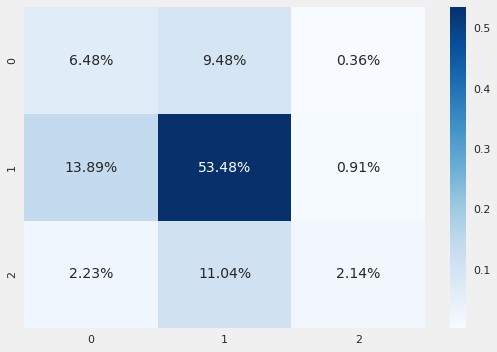

In [146]:
pred = rf.predict(X_validation_st)
score_regression(y_validation, pred)
score_classification(pred_validation, transformData(pred))

Mean absolute error:  1.4065813167395746
--------------------
Mean squared error: 3.129499079772367
--------------------
Root mean squared error: 1.7690390272044219
--------------------
R2 score: -0.061332546254862175
--------------------
              precision    recall  f1-score   support

           0       0.26      0.23      0.24      7117
           1       0.63      0.74      0.68     19330
           2       0.64      0.26      0.37      4344

    accuracy                           0.55     30791
   macro avg       0.51      0.41      0.43     30791
weighted avg       0.54      0.55      0.53     30791

--------------------
The accuracy of the model is: 0.5527589230619336
--------------------
The f1-macro score for the model is: 0.430441118313109
--------------------


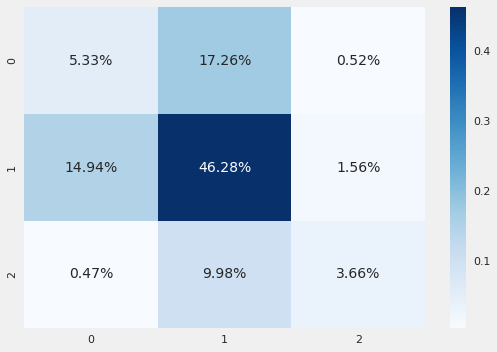

In [147]:
pred = rf.predict(X_test_st)
score_regression(y_test, pred)
score_classification(pred_test, transformData(pred))

### Random Forest model (MinMax Scaler)

In [148]:
rf = rfCMR(n_estimators=1000, n_bins = 256, split_criterion= 6)
rf.fit(X_train_mm,y_train)

RandomForestRegressor()

Mean absolute error:  1.3984429087724732
--------------------
Mean squared error: 3.394500078218054
--------------------
Root mean squared error: 1.8424169121613203
--------------------
R2 score: -0.012271752059087815
--------------------
              precision    recall  f1-score   support

           0       0.29      0.40      0.33      5552
           1       0.72      0.78      0.75     23230
           2       0.63      0.14      0.23      5240

    accuracy                           0.62     34022
   macro avg       0.55      0.44      0.44     34022
weighted avg       0.64      0.62      0.60     34022

--------------------
The accuracy of the model is: 0.6209805420022338
--------------------
The f1-macro score for the model is: 0.43744908426294843
--------------------


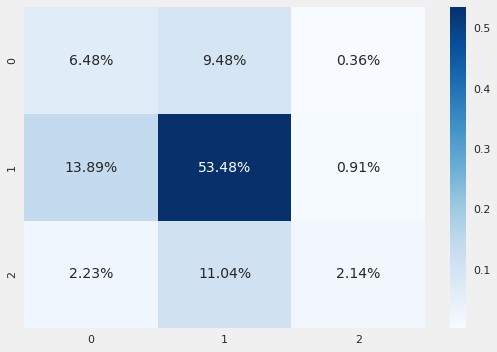

In [149]:
pred = rf.predict(X_validation_mm)
score_regression(y_validation, pred)
score_classification(pred_validation, transformData(pred))

Mean absolute error:  1.4065815516201423
--------------------
Mean squared error: 3.1295008024070796
--------------------
Root mean squared error: 1.7690395140886706
--------------------
R2 score: -0.061333130466021624
--------------------
              precision    recall  f1-score   support

           0       0.26      0.23      0.24      7117
           1       0.63      0.74      0.68     19330
           2       0.64      0.26      0.37      4344

    accuracy                           0.55     30791
   macro avg       0.51      0.41      0.43     30791
weighted avg       0.54      0.55      0.53     30791

--------------------
The accuracy of the model is: 0.5527589230619336
--------------------
The f1-macro score for the model is: 0.430441118313109
--------------------


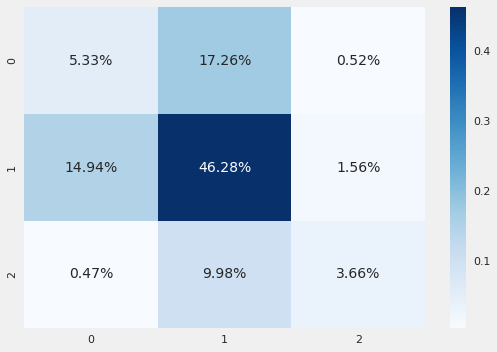

In [150]:
pred = rf.predict(X_test_mm)
score_regression(y_test, pred)
score_classification(pred_test, transformData(pred))

### XGB model (Standard Scaler)

In [151]:
xgb = XGBRegressor(tree_method = 'gpu_hist', n_estimators = 500, booster = 'dart')
xgb.fit(X_train_st,y_train)

XGBRegressor(base_score=0.5, booster='dart', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

Mean absolute error:  1.7294609049906366
--------------------
Mean squared error: 4.980795490622916
--------------------
Root mean squared error: 2.2317695872609513
--------------------
R2 score: -0.48531991803270835
--------------------
              precision    recall  f1-score   support

           0       0.20      0.38      0.26      5552
           1       0.70      0.62      0.66     23230
           2       0.35      0.16      0.22      5240

    accuracy                           0.51     34022
   macro avg       0.41      0.39      0.38     34022
weighted avg       0.56      0.51      0.52     34022

--------------------
The accuracy of the model is: 0.5109047087178884
--------------------
The f1-macro score for the model is: 0.377005054108332
--------------------


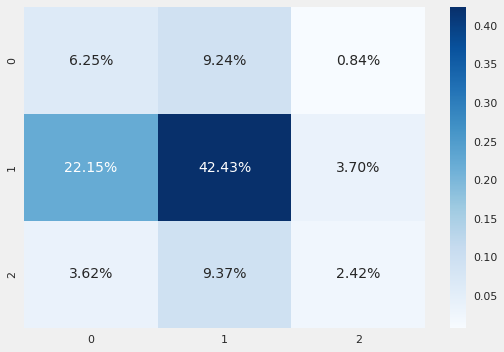

In [152]:
pred = xgb.predict(X_validation_st)
score_regression(y_validation, pred)
score_classification(pred_validation, transformData(pred))

Mean absolute error:  1.5835645237953841
--------------------
Mean squared error: 3.941616750704121
--------------------
Root mean squared error: 1.9853505359769898
--------------------
R2 score: -0.33675263540576283
--------------------
              precision    recall  f1-score   support

           0       0.29      0.30      0.29      7117
           1       0.63      0.64      0.64     19330
           2       0.36      0.31      0.33      4344

    accuracy                           0.52     30791
   macro avg       0.43      0.42      0.42     30791
weighted avg       0.51      0.52      0.52     30791

--------------------
The accuracy of the model is: 0.5166444740346205
--------------------
The f1-macro score for the model is: 0.4206468230843646
--------------------


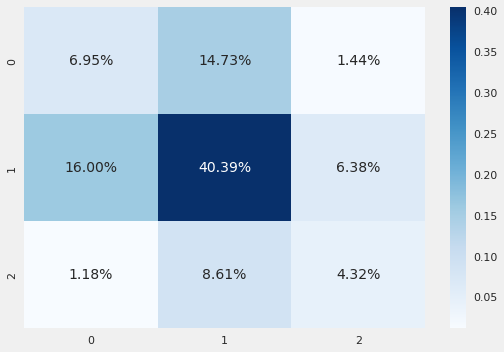

In [153]:
pred = xgb.predict(X_test_st)
score_regression(y_test, pred)
score_classification(pred_test, transformData(pred))

### XGB model (MinMax Scaler)

In [154]:
xgb = XGBRegressor(tree_method = 'gpu_hist', n_estimators = 500, booster = 'dart')
xgb.fit(X_train_mm,y_train)

XGBRegressor(base_score=0.5, booster='dart', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

Mean absolute error:  1.6791092229395077
--------------------
Mean squared error: 4.721309037014019
--------------------
Root mean squared error: 2.1728573439169954
--------------------
R2 score: -0.407938624476172
--------------------
              precision    recall  f1-score   support

           0       0.22      0.42      0.29      5552
           1       0.71      0.64      0.68     23230
           2       0.33      0.15      0.21      5240

    accuracy                           0.53     34022
   macro avg       0.42      0.40      0.39     34022
weighted avg       0.57      0.53      0.54     34022

--------------------
The accuracy of the model is: 0.5316853800482041
--------------------
The f1-macro score for the model is: 0.38997961791637553
--------------------


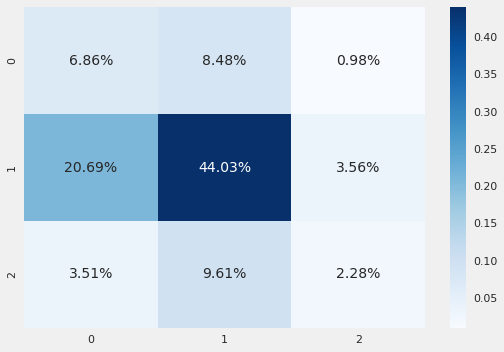

In [155]:
pred = xgb.predict(X_validation_mm)
score_regression(y_validation, pred)
score_classification(pred_validation, transformData(pred))

Mean absolute error:  1.6274713859093208
--------------------
Mean squared error: 4.08243115353447
--------------------
Root mean squared error: 2.020502698224991
--------------------
R2 score: -0.3845081722810646
--------------------
              precision    recall  f1-score   support

           0       0.28      0.33      0.30      7117
           1       0.62      0.60      0.61     19330
           2       0.34      0.30      0.32      4344

    accuracy                           0.50     30791
   macro avg       0.41      0.41      0.41     30791
weighted avg       0.50      0.50      0.50     30791

--------------------
The accuracy of the model is: 0.49644376603552987
--------------------
The f1-macro score for the model is: 0.4120155419782661
--------------------


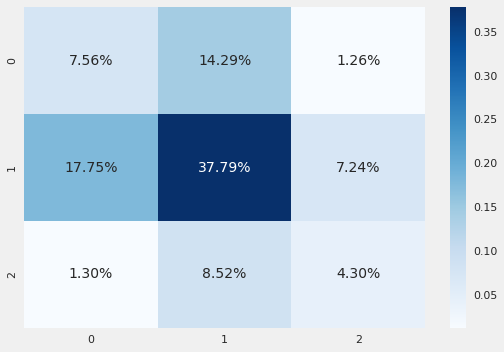

In [156]:
pred = xgb.predict(X_test_mm)
score_regression(y_test, pred)
score_classification(pred_test, transformData(pred))

### KNN model (Standard Scaler)

In [163]:
knn = knnCMR(n_neighbors = 320)
knn.fit(X_train_st, y_train)

KNeighborsRegressor()

Mean absolute error:  1.3727122340475075
--------------------
Mean squared error: 3.2545007868167874
--------------------
Root mean squared error: 1.8040234995190023
--------------------
R2 score: 0.02947734934855928
--------------------
              precision    recall  f1-score   support

           0       0.35      0.54      0.42      5552
           1       0.75      0.77      0.76     23230
           2       0.62      0.18      0.28      5240

    accuracy                           0.64     34022
   macro avg       0.57      0.50      0.49     34022
weighted avg       0.67      0.64      0.63     34022

--------------------
The accuracy of the model is: 0.6438480982893422
--------------------
The f1-macro score for the model is: 0.48803862226413747
--------------------


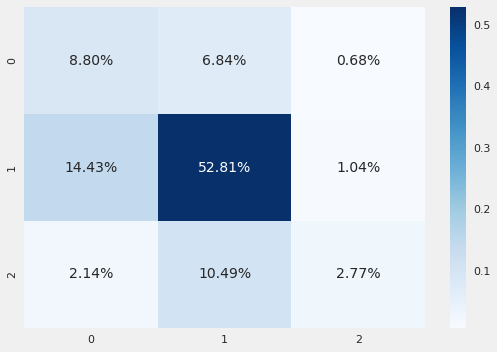

In [164]:
pred = knn.predict(X_validation_st)
score_regression(y_validation, pred)
score_classification(pred_validation, transformData(pred))

Mean absolute error:  1.4473045086303926
--------------------
Mean squared error: 3.2183694028692007
--------------------
Root mean squared error: 1.793981438830737
--------------------
R2 score: -0.0914718637285441
--------------------
              precision    recall  f1-score   support

           0       0.21      0.29      0.24      7117
           1       0.59      0.59      0.59     19330
           2       0.77      0.27      0.40      4344

    accuracy                           0.48     30791
   macro avg       0.52      0.38      0.41     30791
weighted avg       0.53      0.48      0.48     30791

--------------------
The accuracy of the model is: 0.47757461595920886
--------------------
The f1-macro score for the model is: 0.4108388396477321
--------------------


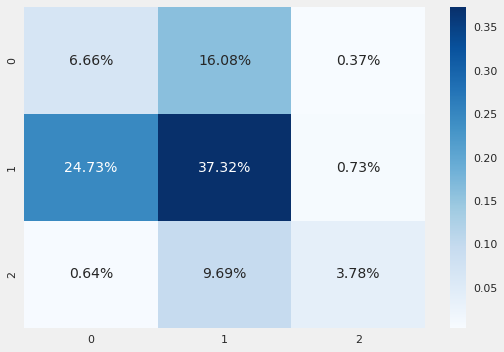

In [165]:
pred = knn.predict(X_test_st)
score_regression(y_test,pred)
score_classification(pred_test, transformData(pred))

### KNN model (MinMax Scaler)

In [166]:
knn = knnCMR(n_neighbors = 320)
knn.fit(X_train_mm, y_train)

KNeighborsRegressor()

Mean absolute error:  1.3570419518967645
--------------------
Mean squared error: 3.2579218539097075
--------------------
Root mean squared error: 1.8049714274496722
--------------------
R2 score: 0.028457155063608908
--------------------
              precision    recall  f1-score   support

           0       0.36      0.46      0.41      5552
           1       0.76      0.82      0.79     23230
           2       0.64      0.22      0.33      5240

    accuracy                           0.67     34022
   macro avg       0.59      0.50      0.51     34022
weighted avg       0.67      0.67      0.65     34022

--------------------
The accuracy of the model is: 0.6688319322791135
--------------------
The f1-macro score for the model is: 0.5067404591649173
--------------------


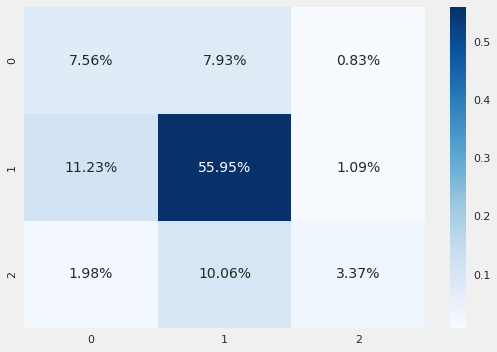

In [167]:
pred = knn.predict(X_validation_mm)
score_regression(y_validation, pred)
score_classification(pred_validation, transformData(pred))

Mean absolute error:  1.4466461384386624
--------------------
Mean squared error: 3.229200514899406
--------------------
Root mean squared error: 1.7969976390912166
--------------------
R2 score: -0.09514510708691115
--------------------
              precision    recall  f1-score   support

           0       0.18      0.24      0.21      7117
           1       0.58      0.58      0.58     19330
           2       0.79      0.29      0.43      4344

    accuracy                           0.46     30791
   macro avg       0.51      0.37      0.40     30791
weighted avg       0.52      0.46      0.47     30791

--------------------
The accuracy of the model is: 0.46299243285375596
--------------------
The f1-macro score for the model is: 0.4043456600085468
--------------------


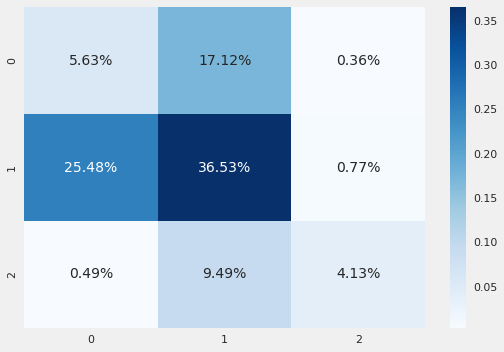

In [168]:
pred = knn.predict(X_test_mm)
score_regression(y_test,pred)
score_classification(pred_test, transformData(pred))

## CLASSIFICATION

### Random Forest model(Standard Scaler)

In [192]:
rf = rfCMC(n_estimators=500, n_bins = 256, split_criterion= 1)
rf.fit(X_train_st, pred_train)

RandomForestClassifier()

              precision    recall  f1-score   support

           0       0.24      0.52      0.33      5552
           1       0.80      0.41      0.54     23230
           2       0.29      0.56      0.38      5240

    accuracy                           0.45     34022
   macro avg       0.44      0.50      0.42     34022
weighted avg       0.63      0.45      0.48     34022

--------------------
The accuracy of the model is: 0.45126682734701073
--------------------
The f1-macro score for the model is: 0.41779906421622165
--------------------


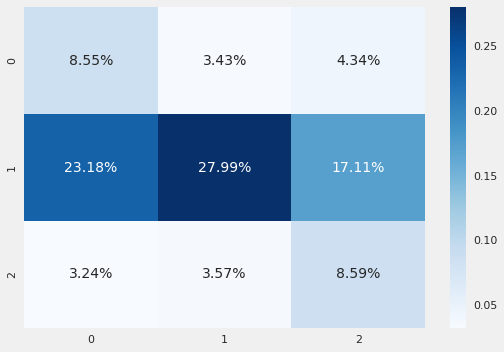

In [193]:
pred = rf.predict(X_validation_st)
score_pure_classification(pred_validation, pred)

              precision    recall  f1-score   support

           0       0.20      0.25      0.22      7117
           1       0.64      0.48      0.54     19330
           2       0.35      0.59      0.44      4344

    accuracy                           0.44     30791
   macro avg       0.40      0.44      0.40     30791
weighted avg       0.50      0.44      0.46     30791

--------------------
The accuracy of the model is: 0.44055081030171156
--------------------
The f1-macro score for the model is: 0.4026238679301637
--------------------


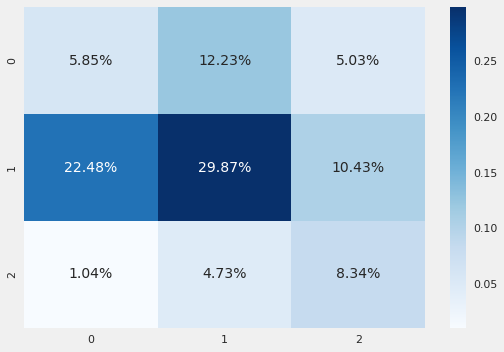

In [194]:
pred = rf.predict(X_test_st)
score_pure_classification(pred_test, pred)

### Random Forest model(MinMax Scaler)

In [ ]:
rf = rfCMC(n_estimators=500, n_bins = 256, split_criterion= 1)
rf.fit(X_train_mm, pred_train)

In [ ]:
pred = rf.predict(X_validation_mm)
score_pure_classification(pred_validation, pred)

In [ ]:
pred = rf.predict(X_test_mm)
score_pure_classification(pred_test, pred)

### XGB model(Standard Scaler)

In [186]:
xgb = XGBClassifier(tree_method = 'gpu_hist', n_estimators = 500, booster = 'dart')
xgb.fit(X_train_st, pred_train)

XGBClassifier(base_score=0.5, booster='dart', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=500,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

              precision    recall  f1-score   support

           0       0.25      0.45      0.32      5552
           1       0.78      0.49      0.61     23230
           2       0.28      0.49      0.36      5240

    accuracy                           0.49     34022
   macro avg       0.44      0.48      0.43     34022
weighted avg       0.62      0.49      0.52     34022

--------------------
The accuracy of the model is: 0.4867732643583564
--------------------
The f1-macro score for the model is: 0.4270956478426995
--------------------


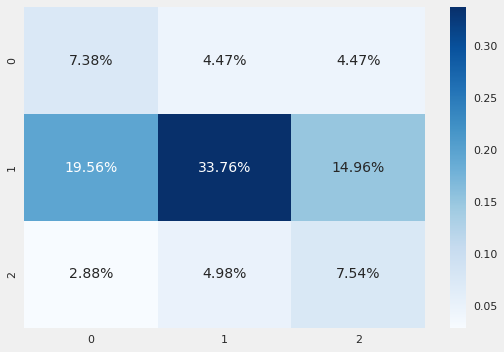

In [187]:
pred = xgb.predict(X_validation_st)
score_pure_classification(pred_validation, pred)

              precision    recall  f1-score   support

           0       0.29      0.34      0.32      7117
           1       0.64      0.42      0.51     19330
           2       0.25      0.55      0.34      4344

    accuracy                           0.42     30791
   macro avg       0.39      0.44      0.39     30791
weighted avg       0.50      0.42      0.44     30791

--------------------
The accuracy of the model is: 0.4192458835373973
--------------------
The f1-macro score for the model is: 0.38668201747691927
--------------------


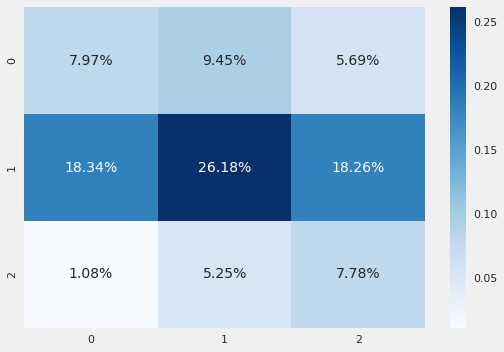

In [188]:
pred = xgb.predict(X_test_st)
score_pure_classification(pred_test, pred)

### XGB model(MinMax Scaler)

In [189]:
xgb = XGBClassifier(tree_method = 'gpu_hist', n_estimators = 500, booster = 'dart')
xgb.fit(X_train_mm, pred_train)

XGBClassifier(base_score=0.5, booster='dart', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=500,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

              precision    recall  f1-score   support

           0       0.25      0.47      0.32      5552
           1       0.78      0.48      0.60     23230
           2       0.27      0.48      0.35      5240

    accuracy                           0.48     34022
   macro avg       0.43      0.48      0.42     34022
weighted avg       0.62      0.48      0.51     34022

--------------------
The accuracy of the model is: 0.48051260948797836
--------------------
The f1-macro score for the model is: 0.423264901141533
--------------------


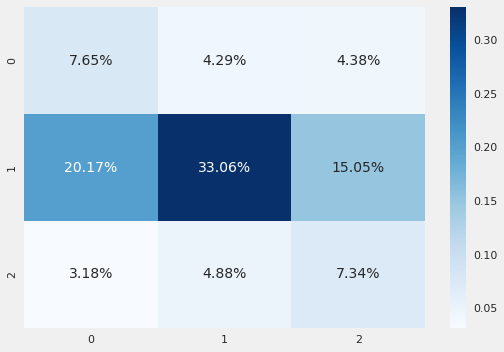

In [190]:
pred = xgb.predict(X_validation_mm)
score_pure_classification(pred_validation, pred)

              precision    recall  f1-score   support

           0       0.29      0.34      0.31      7117
           1       0.66      0.44      0.53     19330
           2       0.26      0.57      0.36      4344

    accuracy                           0.43     30791
   macro avg       0.40      0.45      0.40     30791
weighted avg       0.52      0.43      0.45     30791

--------------------
The accuracy of the model is: 0.4348348543405541
--------------------
The f1-macro score for the model is: 0.3991441221721121
--------------------


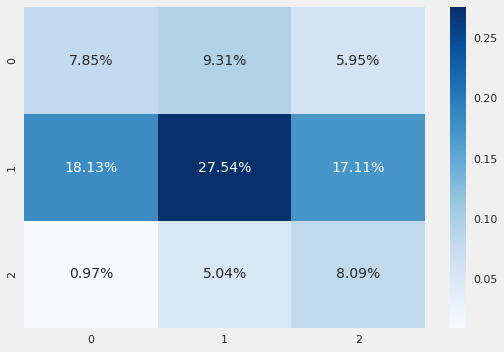

In [191]:
pred = xgb.predict(X_test_mm)
score_pure_classification(pred_test, pred)

### KNN model (Standard Scaler)

In [178]:
knn = knnCMC(n_neighbors = 320)
knn.fit(X_train_st, pred_train)

KNeighborsClassifier()

              precision    recall  f1-score   support

           0       0.27      0.64      0.38      5552
           1       0.84      0.38      0.53     23230
           2       0.27      0.54      0.36      5240

    accuracy                           0.45     34022
   macro avg       0.46      0.52      0.42     34022
weighted avg       0.66      0.45      0.48     34022

--------------------
The accuracy of the model is: 0.4482687672682382
--------------------
The f1-macro score for the model is: 0.4227018284076151
--------------------


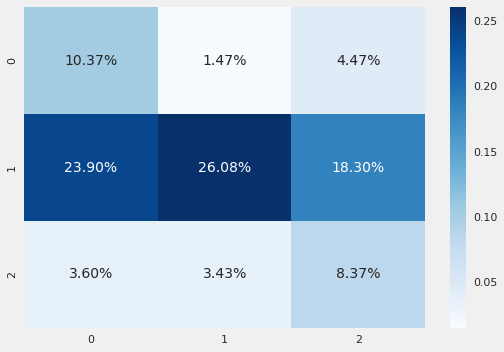

In [179]:
pred = knn.predict(X_validation_st)
score_pure_classification(pred_validation, pred)

              precision    recall  f1-score   support

           0       0.22      0.45      0.29      7117
           1       0.63      0.28      0.39     19330
           2       0.35      0.61      0.45      4344

    accuracy                           0.37     30791
   macro avg       0.40      0.45      0.38     30791
weighted avg       0.50      0.37      0.37     30791

--------------------
The accuracy of the model is: 0.3659186125815985
--------------------
The f1-macro score for the model is: 0.37588604588218694
--------------------


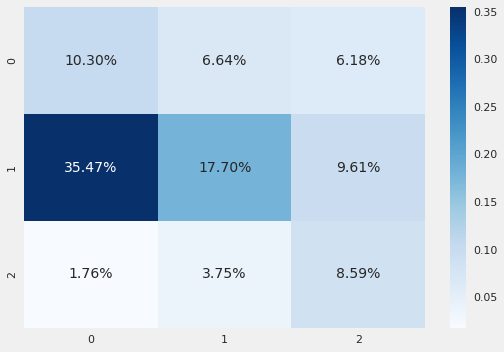

In [181]:
pred = knn.predict(X_test_st)
score_pure_classification(pred_test, pred)

### KNN model (MinMax Scaler)

In [182]:
knn = knnCMC(n_neighbors = 320)
knn.fit(X_train_mm, pred_train)

KNeighborsClassifier()

              precision    recall  f1-score   support

           0       0.28      0.50      0.36      5552
           1       0.83      0.35      0.49     23230
           2       0.24      0.68      0.36      5240

    accuracy                           0.42     34022
   macro avg       0.45      0.51      0.40     34022
weighted avg       0.65      0.42      0.45     34022

--------------------
The accuracy of the model is: 0.42246193639409796
--------------------
The f1-macro score for the model is: 0.40293508666822214
--------------------


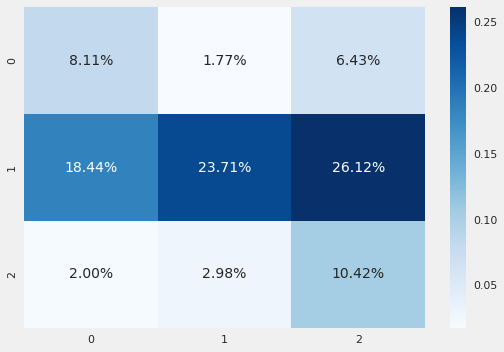

In [183]:
pred = knn.predict(X_validation_st)
score_pure_classification(pred_validation, pred)

              precision    recall  f1-score   support

           0       0.17      0.23      0.19      7117
           1       0.62      0.31      0.41     19330
           2       0.27      0.71      0.39      4344

    accuracy                           0.35     30791
   macro avg       0.35      0.42      0.33     30791
weighted avg       0.47      0.35      0.36     30791

--------------------
The accuracy of the model is: 0.3454905654249618
--------------------
The f1-macro score for the model is: 0.3308967865221659
--------------------


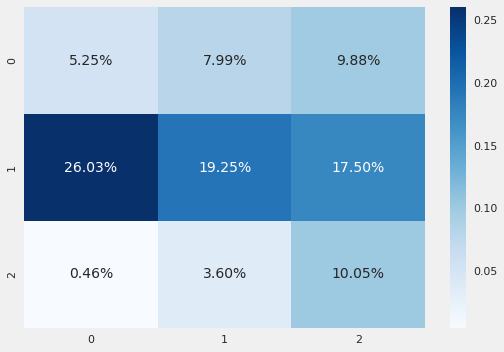

In [184]:
pred = knn.predict(X_test_st)
score_pure_classification(pred_test, pred)